In [3]:
import cv2
import os
import glob
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
utkFaces = pd.read_csv('UTKFaces2.csv')
utkFaces.head()

,age,gender,ethnicity,img_name,pixels
0,85,1,0,20170110182945927.jpg.chip.jpg,"207, 180, 150, 196, 169, 139, 202, 173, 143, 2..."
1,8,0,2,20170117192413109.jpg.chip.jpg,"24, 24, 26, 18, 22, 23, 17, 21, 22, 19, 19, 21..."
2,76,0,0,20170111221823004.jpg.chip.jpg,"244, 248, 249, 244, 248, 249, 244, 248, 251, 2..."
3,85,0,0,20170111210319130.jpg.chip.jpg,"167, 149, 129, 171, 163, 144, 211, 212, 196, 2..."
4,80,0,0,20170117173628559.jpg.chip.jpg,"186, 168, 146, 183, 167, 142, 181, 169, 143, 1..."


In [6]:
#functions takes a series and returns the image and it's labels
def get_image(row):
  age = row['age']
  ethnicity = row['ethnicity']
  gender = row['gender']
  image = np.array(row['pixels'].split(','), 'float32')
  image = image.reshape(64, 64, 3) / 255.0

  return image, age, ethnicity, gender

In [7]:
ethnicity_mapping = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}
gender_mapping = {0:"Male", 1:"Female"}

In [8]:
def show_images():
  plt.figure(figsize=(30, 30))
  for i in range(16):
  #select random image
    idx = random.randint(0, len(utkFaces))
    image, age, ethnicity, gender = get_image(utkFaces.iloc[idx])
    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(age, ethnicity_mapping[ethnicity], gender_mapping[gender]))
  plt.show()

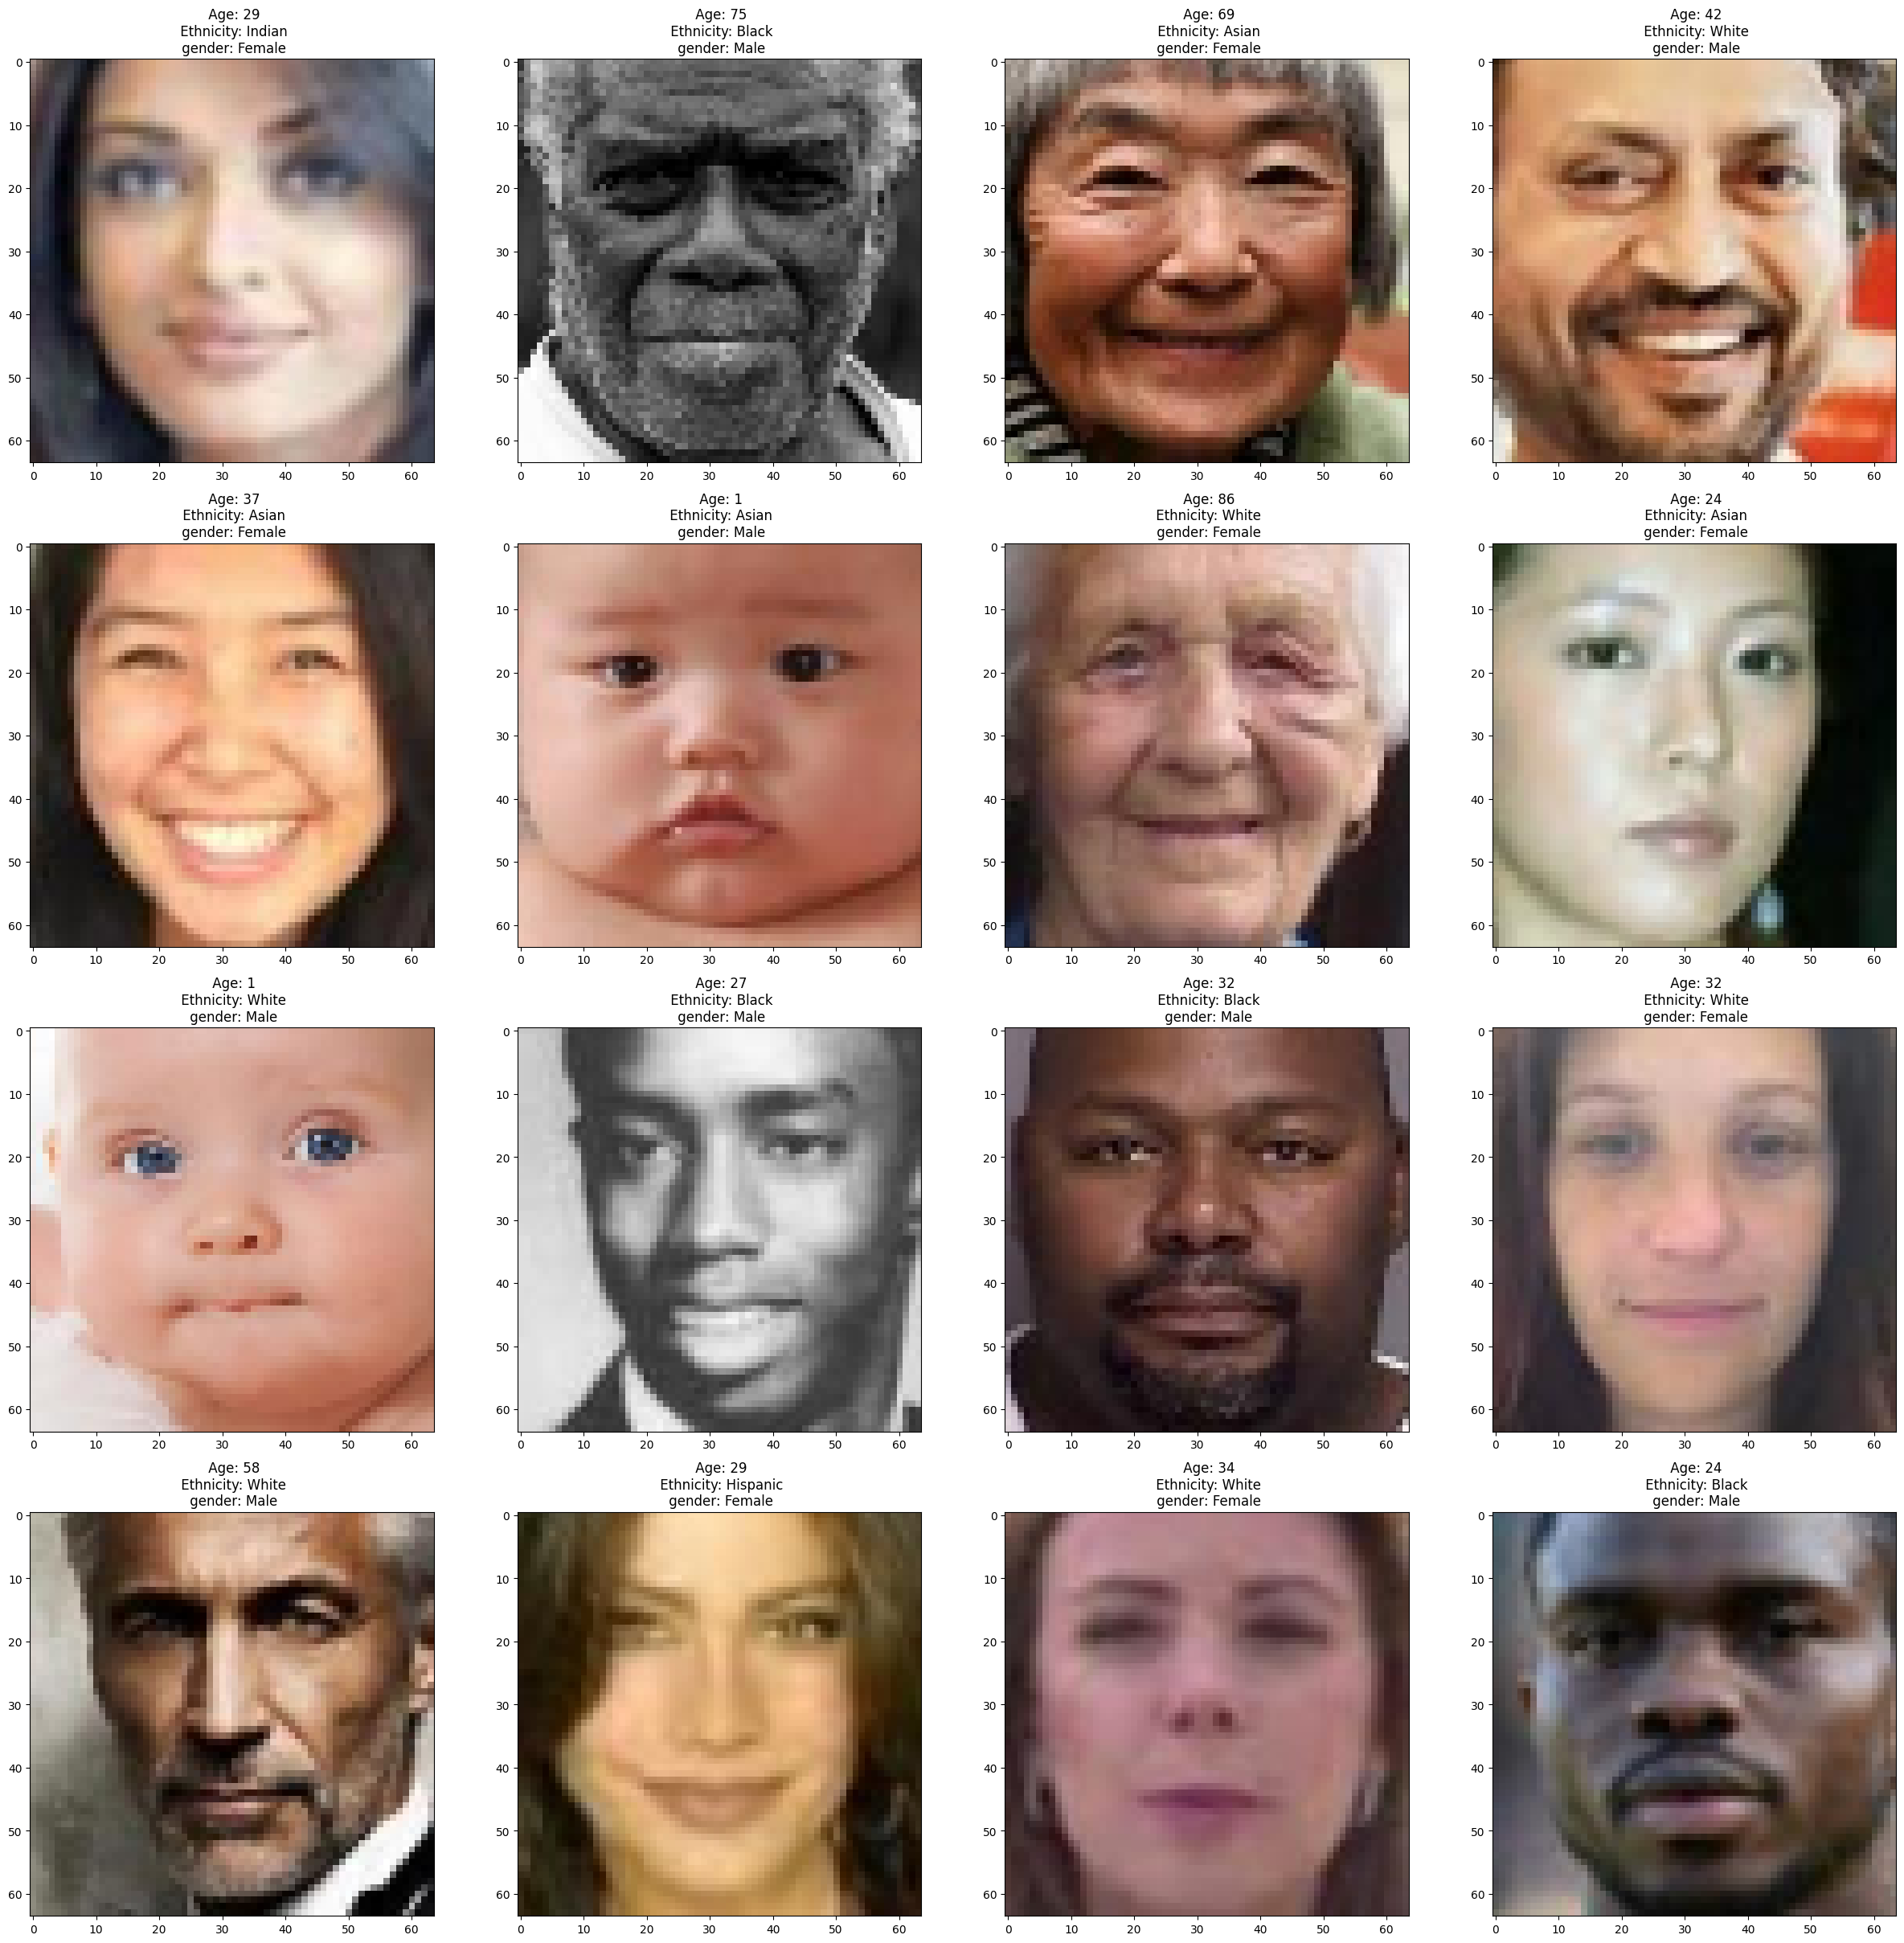

In [9]:
show_images()

In [10]:
utk_images = []
ages_list = []
genders_list = []
ethnicities_list = []

for idx in range((len(utkFaces))): 
  image, age, ethnicity, gender = get_image(utkFaces.iloc[idx])
  if int(age)> 5 and int(age)<90:
    utk_images.append(image)
    ages_list.append(age)
    ethnicities_list.append(ethnicity)
    genders_list.append(gender)

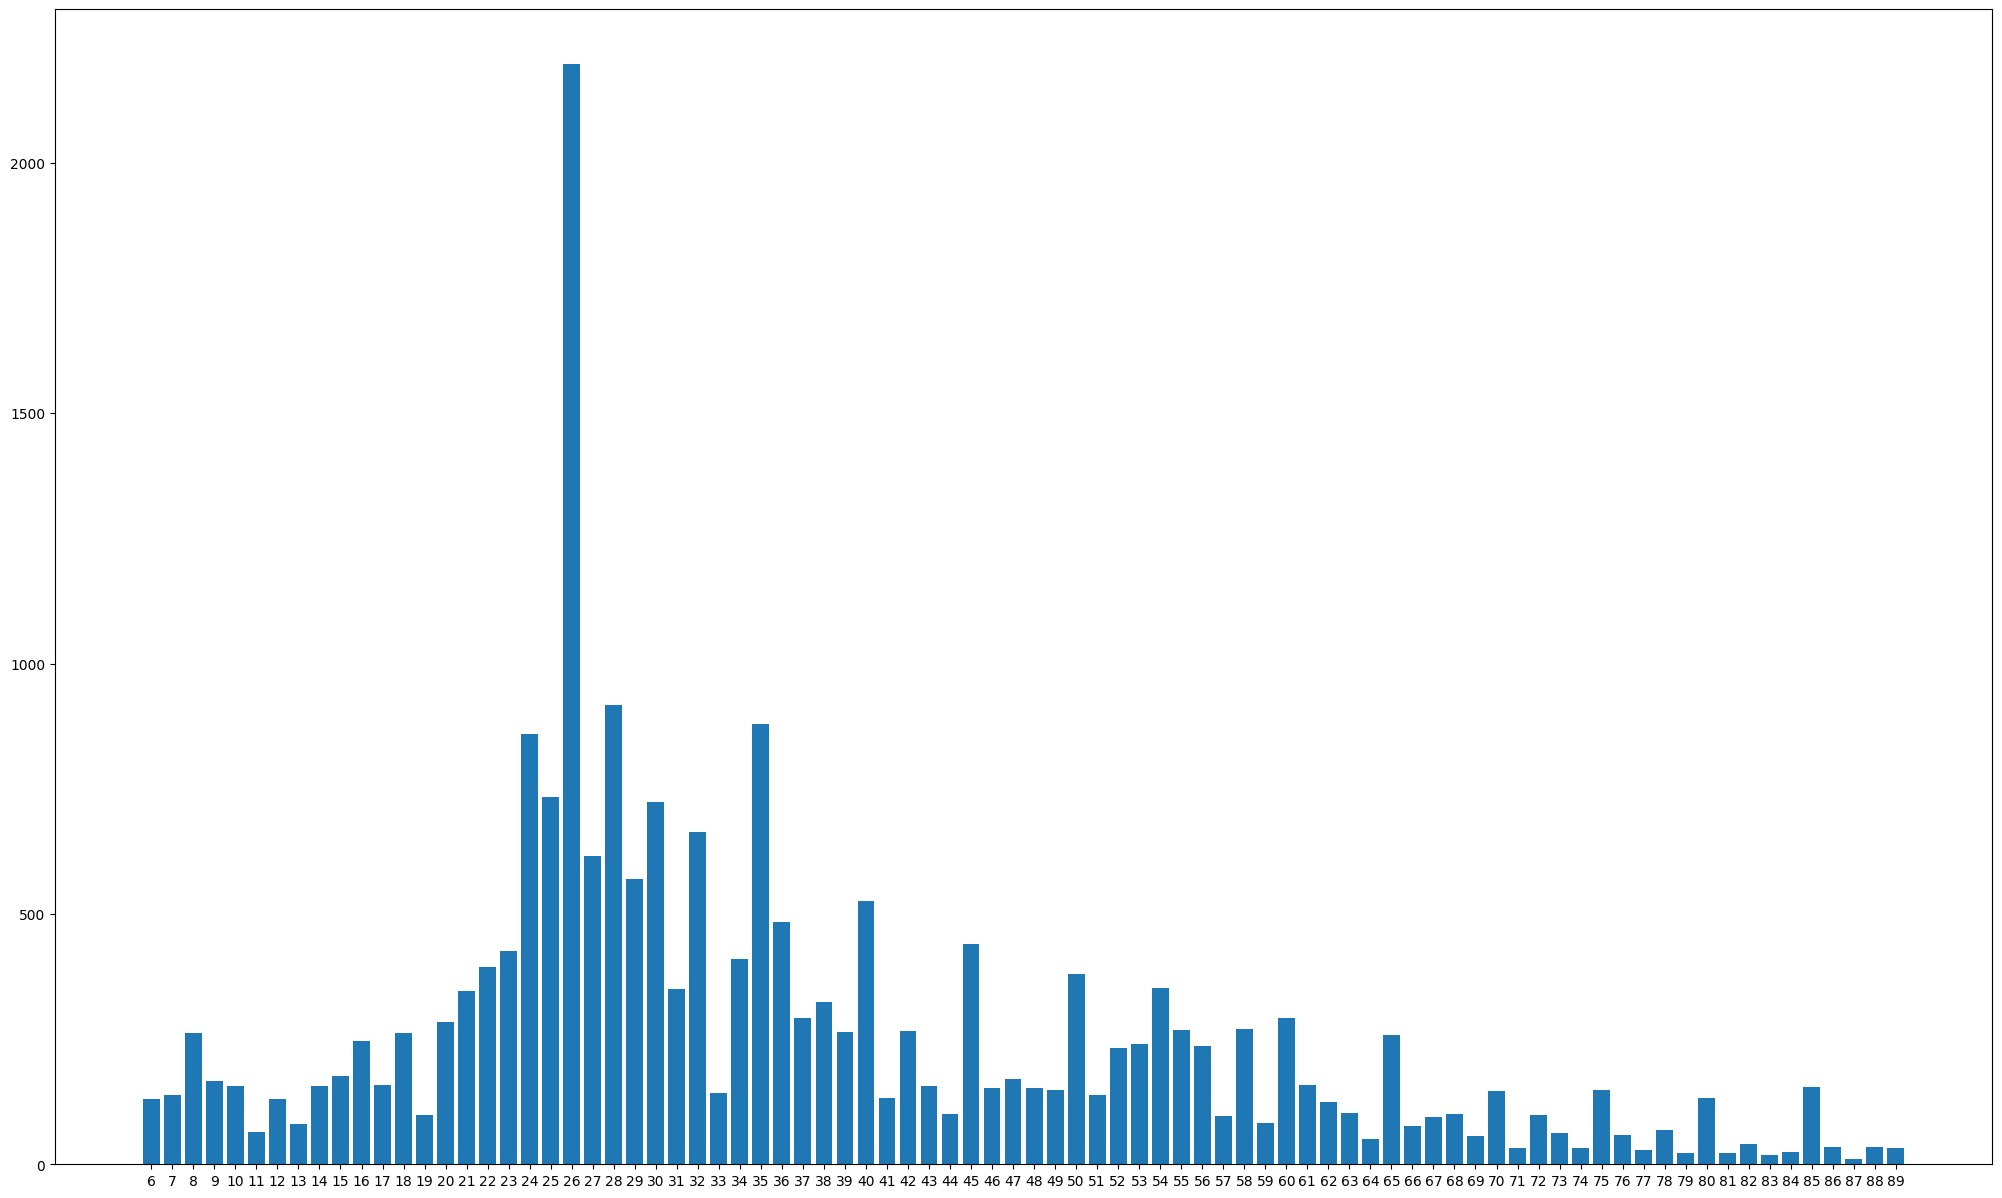

In [11]:
# Age Distribution

plt.figure(1, figsize=(25, 15))
x_age_axis = list(set(ages_list))
x_age_axis = sorted(x_age_axis)
y_age_axis = [ages_list.count(i) for i in x_age_axis]
plt.xticks(np.arange(min(x_age_axis), max(x_age_axis)+1, 1.0))
plt.bar(x_age_axis,y_age_axis)
plt.show()

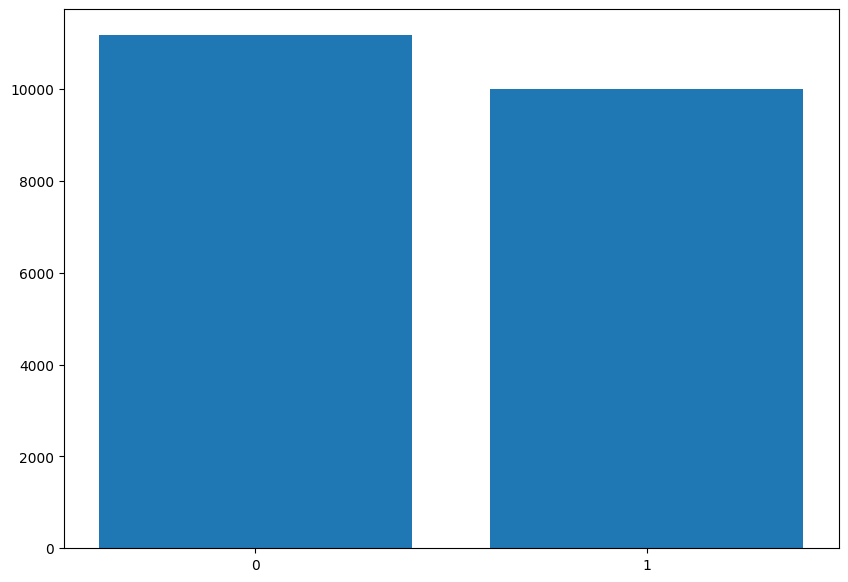

In [12]:
# Gender Distribution 0: Male 1: Female

plt.figure(1, figsize=(10, 7))
x_gen_axis = list(set(genders_list))
x_gen_axis = sorted(x_gen_axis, key=int)
y_gen_axis = [genders_list.count(i) for i in x_gen_axis]
plt.bar(x_gen_axis,y_gen_axis)
plt.xticks(np.arange(min(x_gen_axis), max(x_gen_axis)+1, 1.0))
plt.show()

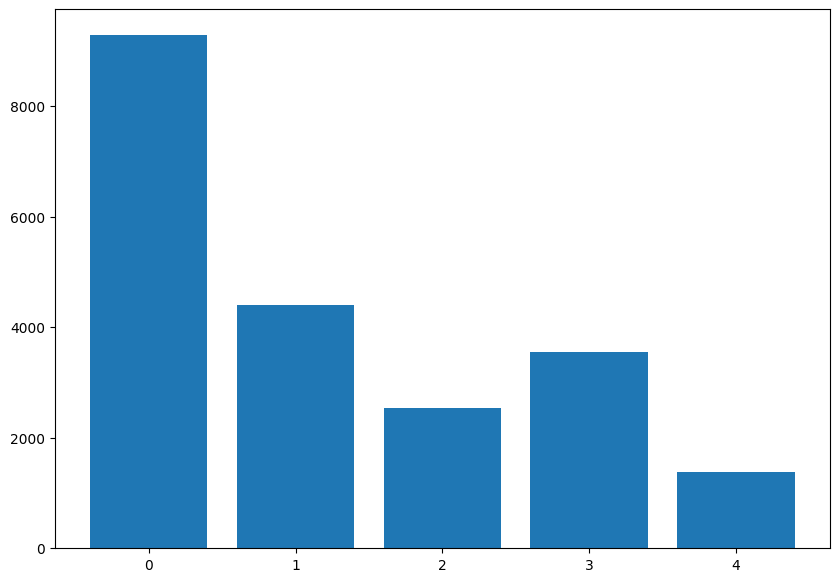

In [13]:
# Ethnicities distribution  0:White, 1:Black, 2:Asian, 3:Indian, 4:Hispanic

plt.figure(1, figsize=(10, 7))
x_ethn_axis = list(set(ethnicities_list))
x_ethn_axis = sorted(x_ethn_axis, key=int)
y_ethn_axis = [ethnicities_list.count(i) for i in x_ethn_axis]
plt.bar(x_ethn_axis,y_ethn_axis)
plt.xticks(np.arange(min(x_ethn_axis), max(x_ethn_axis)+1, 1.0))
plt.show()

In [14]:
matrix = np.zeros((len(utk_images),3),dtype='float32')
images = np.zeros((len(utk_images),64,64,3),dtype = 'float32')

for i in range(len(utk_images)):
  matrix[i,0] = int(ages_list[i])
  matrix[i,1] = int(genders_list[i])
  matrix[i,2] = int(ethnicities_list[i])
  images[i] = utk_images[i]

In [15]:

from sklearn.model_selection import train_test_split
#training and test sets
X_train1, X_test, y_train1, y_test = train_test_split(images, matrix, test_size=0.2,shuffle=True)
print("Samples in Training:",X_train1.shape[0])
print("Samples in Validation:",X_test.shape[0])

Samples in Training: 16938
Samples in Validation: 4235


In [16]:
# Data Augmentation function - shifting images
def translate(img, shift, direction, roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img

In [17]:
# data augmentation function - flipping images

def flip(img): 
  img = cv2.flip(img, 1)
  return img 
     

In [18]:
# Data augmentation function - distort images

def distort(img, orientation='horizontal', func=np.sin, x_scale=0.05, y_scale=5):
  assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
  assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
  assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
  assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
  img_dist = img.copy()
    
  def shift(x):
    return int(y_scale * func(np.pi * x * x_scale))
    
    for c in range(3):
      for i in range(img.shape[orientation.startswith('ver')]):
        if orientation.startswith('ver'):
          img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
        else:
          img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))
            
  return img_dist

In [19]:
#compute the new avg in the training set 
ages = []
eth = []
for i in range(0,len(X_train1)): 
  ages.append(y_train1[i,0])
  eth.append(y_train1[i,2])

#ages average in train set
a_samples = list(set(ages))
na_samples = [ages.count(i) for i in a_samples]

age_train_avg = sum(na_samples)/len(a_samples)
print(age_train_avg)

#ethnicities average in train set
e_samples = list(set(eth))
ne_samples = [eth.count(i) for i in e_samples]

eth_train_avg = sum(ne_samples)/len(e_samples)
print(eth_train_avg)

201.64285714285714
3387.6


In [20]:
j = 0
samples_ages = []
samples_eth = []

#take ages under the ages avg 
for i in a_samples:
  if na_samples[j] < age_train_avg:
    samples_ages.append(i)
  j+=1

j=0
#take ethnicity classes under the ethnicity avg 
for i in e_samples:
  if ne_samples[j] < eth_train_avg:
    samples_eth.append(i)
  j+=1

minor_age_avg = samples_ages
minor_eth_avg = samples_eth

#classes under the average
print(minor_age_avg) #ages
print(minor_eth_avg) #ethnicities

[6.0, 7.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 19.0, 33.0, 41.0, 43.0, 44.0, 46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 56.0, 57.0, 59.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0]
[2.0, 3.0, 4.0]


In [23]:

count_tot_ages = 0
count_tot_eth = 0
moves = ['right', 'left', 'down', 'up']
pos = ['ver', 'hor']
count = 0
x_param = [0.01, 0.02, 0.03]
y_param = [1, 2] 

for i in range(0,len(y_train1)): 
  age = y_train1[i,0]
  eth = y_train1[i,2]
  if age in minor_age_avg: 
    count_tot_ages+=1
  if eth in minor_eth_avg: 
    count_tot_eth+=1
  
  if (age in minor_age_avg) and (eth in minor_eth_avg):
    count +=1
  
len_aug = count
images2 = np.zeros((len_aug,64,64,3),dtype = 'float32')
matrix2 = np.zeros((len_aug,3),dtype='float32')

j = 0
for i in range(0,len(y_train1)): 
  
  img = X_train1[i]

  age = y_train1[i,0]
  gender =  y_train1[i,1]
  eth = y_train1[i,2]

  n = random.uniform(0,1)

  if (age in minor_age_avg) and (eth in minor_eth_avg): 
    
    if n >= 0.8: 
      
      dist = random.choice(pos)
      x_p = random.choice(x_param)
      y_p = random.choice(y_param)
  
      img = distort(img, orientation=dist, x_scale=x_p, y_scale=y_p)

      matrix2[j,0] = age
      matrix2[j,1] = gender
      matrix2[j,2] = eth

      images2[j] = img


    if n < 0.8 and n >= 0.5:
      
      move = random.choice(moves)
      shf = random.randint(1,3)
      img = translate(img,shift=shf,direction=move)

      matrix2[j,0] = age
      matrix2[j,1] = gender
      matrix2[j,2] = eth

      images2[j] = img

    
    if n < 0.5: 
      
      img = flip(img)
      
      matrix2[j,0] = age
      matrix2[j,1] = gender
      matrix2[j,2] = eth

      images2[j] = img

    j+=1

In [24]:

X_train2_len = X_train1.shape[0] + images2.shape[0]

X_train2 = np.zeros((X_train2_len,64,64,3),dtype = 'float32')
y_train2 = np.zeros((X_train2_len,3),dtype = 'float32')

for i in range(0,len(X_train1)): 
  X_train2[i] = X_train1[i]

  y_train2[i,0] = y_train1[i,0]
  y_train2[i,1] = y_train1[i,1]
  y_train2[i,2] = y_train1[i,2]

j = 0
for i in range(len(X_train1), len(X_train2)):
  X_train2[i] = images2[j]

  y_train2[i,0] = matrix2[j,0]
  y_train2[i,1] = matrix2[j,1]
  y_train2[i,2] = matrix2[j,2]

  j+= 1

In [25]:

X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2, test_size=0.2, shuffle=True)
print("Samples in Training:",X_train.shape[0])
print("Samples in Validation:",X_val.shape[0])

Samples in Training: 14479
Samples in Validation: 3620


In [26]:

class_white = 0
class_black = 0
class_asian = 0
class_indian = 0
class_hispanic = 0

for j in range(0,len(y_train)): 
  i = int(y_train[j,2])
  if i == 0: 
    class_white+=1
  if i == 1: 
    class_black+=1
  if i == 2: 
    class_asian+=1
  if i == 3: 
    class_indian+=1
  if i == 4: 
    class_hispanic+=1
print(class_white,class_black,class_asian,class_indian,class_hispanic)

class_male = 0
class_female = 0

for j in range(0,len(y_train)): 
  i = int(y_train[j,1])
  if i == 0: 
    class_male+=1
  if i == 1: 
    class_female+=1
  

6013 2758 1927 2717 1064


In [27]:

def custom_mse(y_true, y_pred):
  # calculating squared difference between target and predicted values 
  loss = K.square(y_pred - y_true)  # (batch_size, 2)
  # summing both loss values along batch dimension 
  loss = (K.sum(loss, axis=1))/100      # (batch_size,)
  return loss

In [28]:
from tensorflow.keras.optimizers import RMSprop
batch_size = 128
lr = 0.001
input_layer = Input(shape = (64, 64, 3))

#CNN used as BASE for feature extraction

conv1 = Conv2D(32, (3,3), activation='relu', padding='same', name='base_conv1')(input_layer)
batch1 = BatchNormalization(name='batch1')(conv1)

conv2 = Conv2D(32, (3,3), activation='relu', padding='same',name='base_conv2')(batch1)
batch2 = BatchNormalization(name='batch2')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2), name='base_pool2')(batch2)
drop2 = Dropout(0.25, name= 'base_drop2')(pool2)

conv3 = Conv2D(64, (3,3), activation='relu', padding='same', name='base_conv3')(drop2)
batch3 = BatchNormalization(name = 'batch3')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2), name='base_pool3')(batch3)
drop3 = Dropout(0.25, name= 'base_drop3')(pool3)

flat = Flatten(name= 'base_flatten')(drop3)

In [29]:
# Age Model
dropout_age = Dropout(0.5)
model_a = Dense(64,activation='relu', name = 'age_dense1')(flat)
model_a = BatchNormalization(name = 'age_batch1')(model_a)
model_a = dropout_age(model_a)


model_a = Dense(64,activation='relu', name = 'age_dense2')(model_a)
model_a = BatchNormalization(name = 'age_batch2')(model_a)
model_a = dropout_age(model_a)

model_a = Dense(1,activation='relu', name='age')(model_a)
     

In [30]:
# Gender Model
dropout_gender = Dropout(0.5)
model_g = Dense(64,activation='relu', name = 'gender_dense1')(flat)
model_g = BatchNormalization(name='gender_batch1')(model_g)
model_g = dropout_gender(model_g)

model_g = Dense(64,activation='relu', name = 'gender_dense2')(model_g)
model_g = BatchNormalization(name='gender_batch2')(model_g)
model_g = dropout_gender(model_g)

model_g= Dense(1, activation='sigmoid', name='gender')(model_g)
     

In [31]:
# Ethnicity Model
dropout_eth = Dropout(0.5)
model_e = Dense(64,activation='relu', name = 'eth_dense1')(flat)
model_e = BatchNormalization(name = 'eth_batch1')(model_e)
model_e = dropout_eth(model_e)

model_e = Dense(64,activation='relu', name = 'eth_dense2')(model_e)
model_e = BatchNormalization(name='eth_batch2')(model_e)
model_e = dropout_eth(model_e)

model_e = Dense(5, activation='softmax', name='ethnicity')(model_e)

In [32]:

#Final model
model = Model(inputs=input_layer, outputs=[model_a,model_g, model_e])

adam = Adam(learning_rate=lr)
model.compile(
    loss = {
        'age' : custom_mse,
        'gender': 'binary_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    }, 
    
    optimizer=adam, 
    metrics={
        'age':'mae',
        'gender': 'accuracy',
        'ethnicity': 'accuracy'
    })
model.summary()

plot_model(model, to_file='stacked_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_conv1 (Conv2D) │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch1              │ (None, 64, 64,    │        128 │ base_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_conv2 (Conv2D) │ (None, 64, 64,    │      9,248 │ batch1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch2              │ (None, 64, 64,    │        128 │ base_conv2[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_pool2          │ (None, 32, 32,    │          0 │ batch2[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_drop2          │ (None, 32, 32,    │          0 │ base_pool2[0][0]  │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_conv3 (Conv2D) │ (None, 32, 32,    │     18,496 │ base_drop2[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch3              │ (None, 32, 32,    │        256 │ base_conv3[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_pool3          │ (None, 16, 16,    │          0 │ batch3[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_drop3          │ (None, 16, 16,    │          0 │ base_pool3[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_flatten        │ (None, 16384)     │          0 │ base_drop3[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_dense1 (Dense)  │ (None, 64)        │  1,048,640 │ base_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_dense1       │ (None, 64)        │  1,048,640 │ base_flatten[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eth_dense1 (Dense)  │ (None, 64)        │  1,048,640 │ base_flatten[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_batch1          │ (None, 64)        │        256 │ age_dense1[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_batch1       │ (None, 64)        │        256 │ gender_dense1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,189,543 (12.17 MB)

 Trainable params: 3,188,519 (12.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [33]:

steps_per_epoch=len(X_train)//batch_size

#Stop training when a monitored metric has stopped improving
# loss is a parameter which  is a better estimator for EarlyStopping, since we can check if the model is overfitting 
# this is not guaranteed by the accurancy monitoring
EarlyStopping = EarlyStopping(#monitor='val_ethnicity_loss',
                              monitor = 'val_loss',
                              min_delta=0.01,
                              patience=4,
                              verbose=1,
                              mode='min',
                              baseline=None,
                              restore_best_weights=True)

#Reduce learning rate when a metric has stopped improving
#da sostituire
rlr = ReduceLROnPlateau(monitor="val_loss",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="min",
                            min_delta=0.01)

model_save = ModelCheckpoint(filepath='models/trained_Model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             #monitor = 'val_ethnicity_loss',
                             mode = 'min')

try:

    history = model.fit(X_train,[y_train[:,0],y_train[:,1],y_train[:,2]], 
                                  epochs=100, verbose=1, 
                                  validation_data=(X_val,[y_val[:,0],y_val[:,1], y_val[:,2]]),
                                  #shuffle = True,
                                  steps_per_epoch=steps_per_epoch, 
                                  callbacks=[EarlyStopping,rlr, model_save])

except KeyboardInterrupt:
    pass

Epoch 1/100


In [34]:
import os
models_dir = 'models/'

def loadmodel(problem):
    filename = os.path.join(models_dir,'%s.h5' %problem)
    try:
        model = load_model(filename,custom_objects={'custom_mse':custom_mse})
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

model = loadmodel('trained_Model')


Model loaded successfully from file models/trained_Model.h5



In [35]:

def model_performance(history): 
  figure, axis = plt.subplots(1, 7, figsize=(50,5))
  axis = axis.ravel()
  
  for i,element in enumerate(['loss','age_loss', 'gender_loss', 'ethnicity_loss','age_mae','gender_accuracy', 'ethnicity_accuracy']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [36]:
model_performance(history)

NameError: name 'history' is not defined

In [37]:

loss, age_loss, gender_loss, ethnicity_loss, age_mae, gender_accuracy, ethnicity_accuracy = model.evaluate(X_test,[y_test[:,0],y_test[:,1],y_test[:,2]],verbose=1)
print('Test loss: {}'.format(loss))
print('Test age loss: {}'.format(age_loss))
print('Test gender loss: {}'.format(gender_loss))
print('Test ethnicity loss : {}'.format(ethnicity_loss))
print('Test age mae : {}'.format(age_mae))
print('Test gender accuracy : {}'.format(gender_accuracy))
print('Test ethnicity accuracy : {}'.format(ethnicity_accuracy))

133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - age_loss: 0.6083 - age_mean_absolute_error: 5.9264 - ethnicity_accuracy: 0.8902 - ethnicity_loss: 0.3509 - gender_accuracy: 0.9740 - gender_loss: 0.0886 - loss: 1.0494
Test loss: 1.0494446754455566
Test age loss: 0.6083272695541382
Test gender loss: 0.08861253410577774
Test ethnicity loss : 0.3508589267730713
Test age mae : 5.926356315612793
Test gender accuracy : 0.8902007341384888
Test ethnicity accuracy : 0.9740259647369385


133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step


Text(113.9222222222222, 0.5, 'True label')

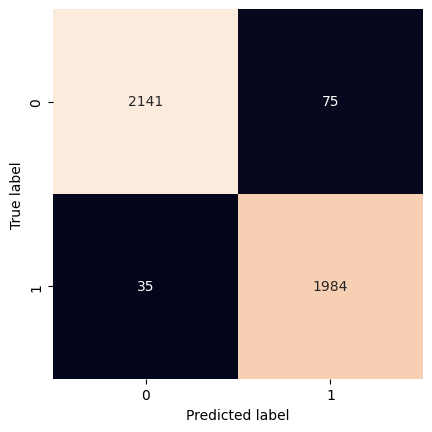

In [ ]:
# Gender Confusion Matrix
values_cm = model.predict(X_test, verbose=1)
Ypred = np.where(np.array(values_cm[1])>0.5,1,0)
Ytest = y_test[:,1]
cm = confusion_matrix(Ytest, Ypred)

sns.heatmap(cm,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
     

133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step


Text(113.9222222222222, 0.5, 'True label')

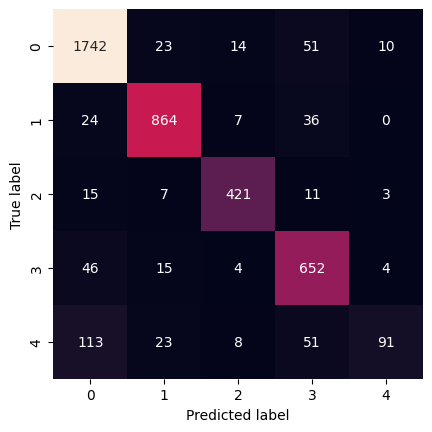

In [39]:
# Ethnicity Confusion Matrix
values_cm = model.predict(X_test, verbose=1)
Ypred = np.argmax(values_cm[2], axis=1)
Ytest = y_test[:,2]
cm = confusion_matrix(Ytest, Ypred)

sns.heatmap(cm,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1','2','3','4'],
            yticklabels=['0', '1','2', '3', '4'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [ ]:
def display(img):
    plt.imshow(img)
    plt.show()
    

#age ranges
def get_age(age):
  age_range = 0

  if age >= 5 and age <=12:
    age_range = 'young adult: 5-12 '
  if age >= 13 and age <=19:
    age_range = 'young adult: 13-19'
  if age >= 20 and age <=29:
    age_range = 'young adult: 20-29 '
  if age >= 30 and age <=39:
    age_range = 'young adult: 30-39'
  if age >= 40 and age <=49:
    age_range = 'middle-aged adult: 40-49'
  if age >= 50 and age <=59:
    age_range = 'middle-aged adult: 50-59'
  if age >= 60 and age <=69:
    age_range = 'old adult: 60-69'
  if age >= 70 and age <=79:
    age_range = 'old adult: 70-79'
  if age >= 80 and age <=89:
    age_range = 'old adult: 80-89'
  if age >= 90:
    age_range = 'old adult: 90+: '
  if age < 5 or age > 90: 
    age_range = 'unknown'

  return age_range


#gender estimation based on the output probability
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

#take the most probable index of the predicted ethnicities array
def get_ethnicity(probabilities):
  idx = np.argmax(probabilities[0])
  return ethnicity_mapping[idx]

#prediction on given samples
def make_prediction(sample): 
  values = model.predict(np.array([sample], dtype='float32'))
  return values

def get_result(sample):
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    val = make_prediction(sample)
    sys.stdout = old_stdout 
    age = round(np.max(val[0]))
    age_range = get_age(age)
    gender = get_gender(val[1])
    ethnicity = get_ethnicity(val[2])
    print("Predicted Gender:",gender,"\n","Predicted Age:", age,"\n",age_range,"\n","Predicted Ethnicity:",ethnicity)
     

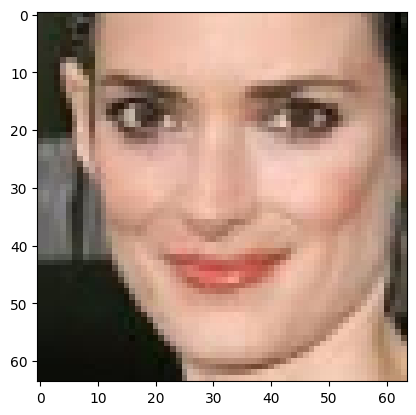

True Gender: Female , True Age: 29 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 32 
 young adult: 30-39 
 Predicted Ethnicity: White


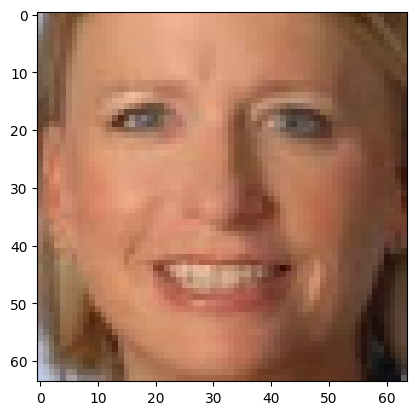

True Gender: Female , True Age: 40 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 46 
 middle-aged adult: 40-49 
 Predicted Ethnicity: White


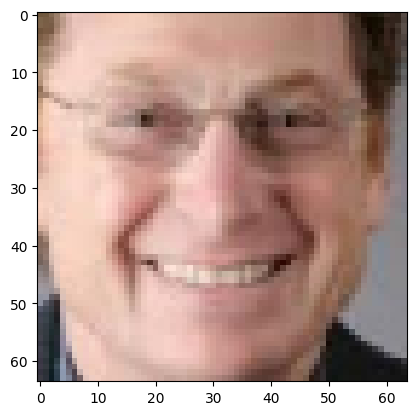

True Gender: Male , True Age: 52 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 54 
 middle-aged adult: 50-59 
 Predicted Ethnicity: White


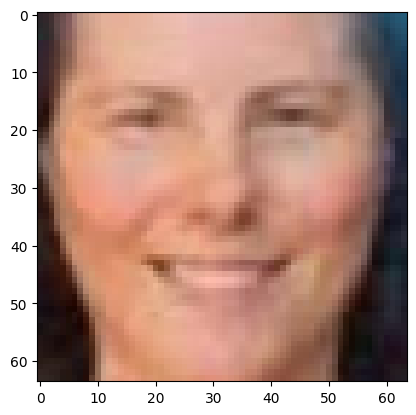

True Gender: Female , True Age: 39 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 37 
 young adult: 30-39 
 Predicted Ethnicity: White


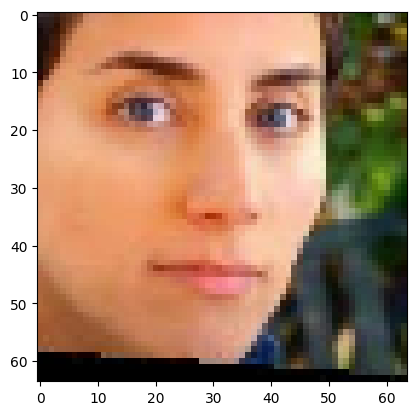

True Gender: Female , True Age: 29 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 22 
 young adult: 20-29  
 Predicted Ethnicity: Indian


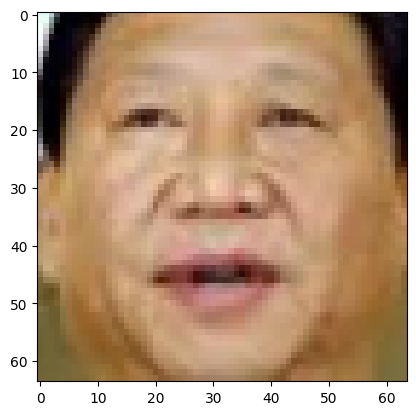

True Gender: Male , True Age: 60 , True Ethnicity:  Asian
Predicted Gender: Male 
 Predicted Age: 64 
 old adult: 60-69 
 Predicted Ethnicity: Asian


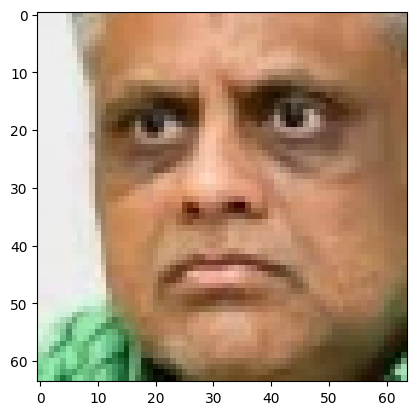

True Gender: Male , True Age: 50 , True Ethnicity:  Indian
Predicted Gender: Male 
 Predicted Age: 53 
 middle-aged adult: 50-59 
 Predicted Ethnicity: Indian


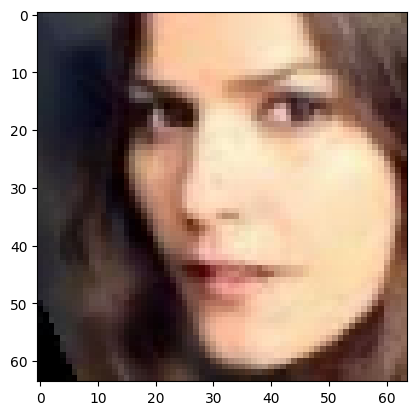

True Gender: Female , True Age: 28 , True Ethnicity:  Hispanic
Predicted Gender: Female 
 Predicted Age: 25 
 young adult: 20-29  
 Predicted Ethnicity: White


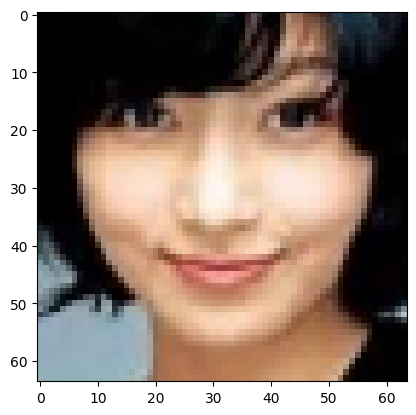

True Gender: Female , True Age: 27 , True Ethnicity:  Asian
Predicted Gender: Female 
 Predicted Age: 25 
 young adult: 20-29  
 Predicted Ethnicity: Asian


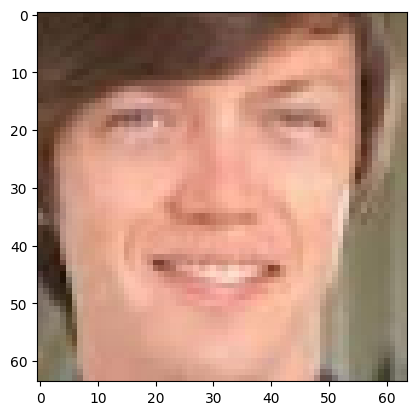

True Gender: Male , True Age: 34 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 28 
 young adult: 20-29  
 Predicted Ethnicity: White


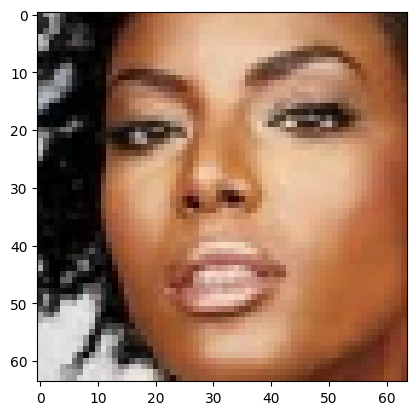

True Gender: Female , True Age: 35 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 24 
 young adult: 20-29  
 Predicted Ethnicity: Black


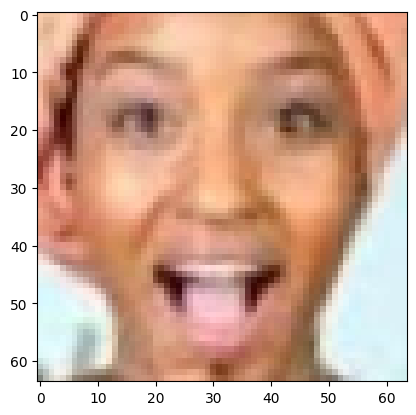

True Gender: Female , True Age: 26 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 37 
 young adult: 30-39 
 Predicted Ethnicity: Black


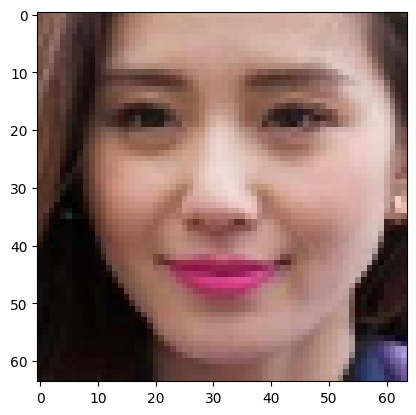

True Gender: Female , True Age: 27 , True Ethnicity:  Asian
Predicted Gender: Female 
 Predicted Age: 23 
 young adult: 20-29  
 Predicted Ethnicity: Asian


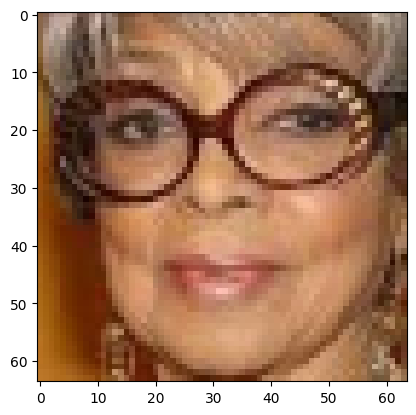

True Gender: Female , True Age: 72 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 62 
 old adult: 60-69 
 Predicted Ethnicity: White


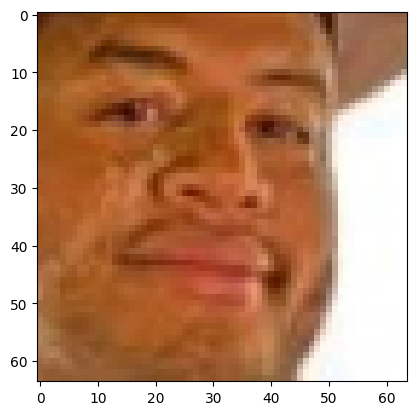

True Gender: Male , True Age: 28 , True Ethnicity:  Black
Predicted Gender: Male 
 Predicted Age: 43 
 middle-aged adult: 40-49 
 Predicted Ethnicity: Black


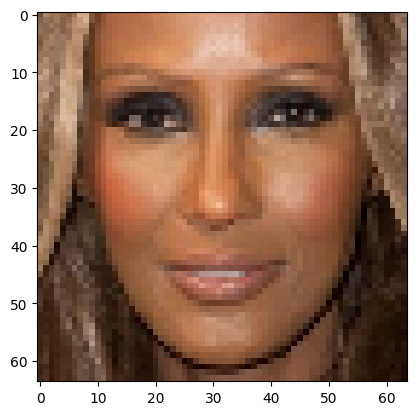

True Gender: Female , True Age: 56 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 41 
 middle-aged adult: 40-49 
 Predicted Ethnicity: White


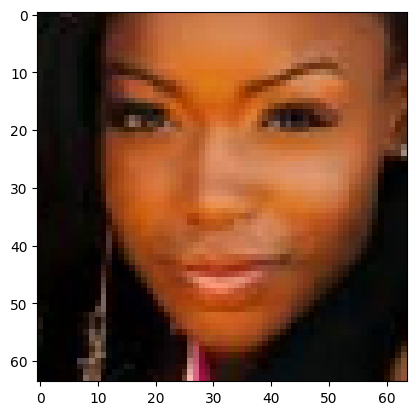

True Gender: Female , True Age: 24 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 29 
 young adult: 20-29  
 Predicted Ethnicity: Black


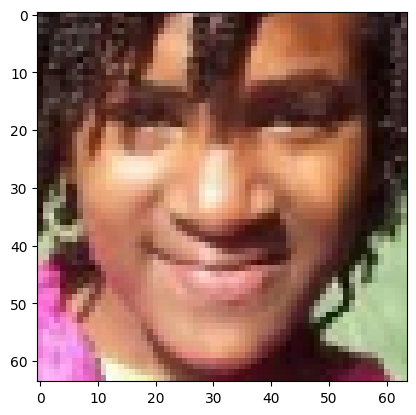

True Gender: Female , True Age: 12 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 35 
 young adult: 30-39 
 Predicted Ethnicity: Black


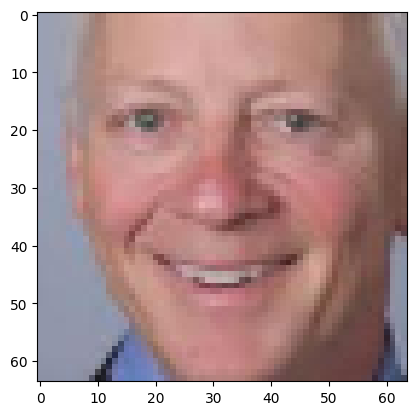

True Gender: Male , True Age: 57 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 59 
 middle-aged adult: 50-59 
 Predicted Ethnicity: White


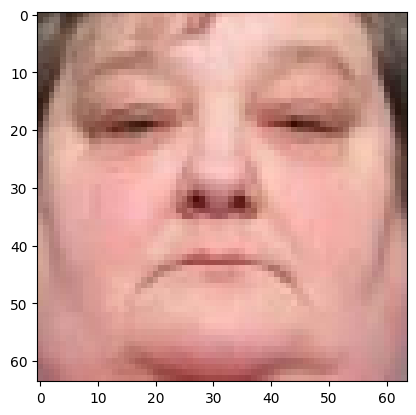

True Gender: Female , True Age: 50 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 48 
 middle-aged adult: 40-49 
 Predicted Ethnicity: White


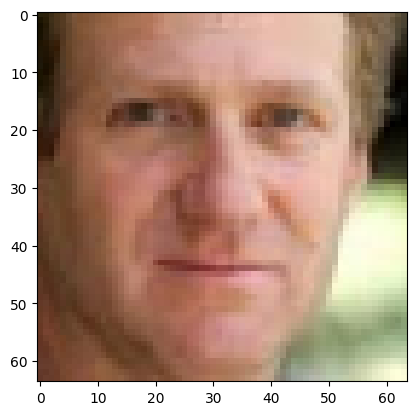

True Gender: Male , True Age: 49 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 51 
 middle-aged adult: 50-59 
 Predicted Ethnicity: White


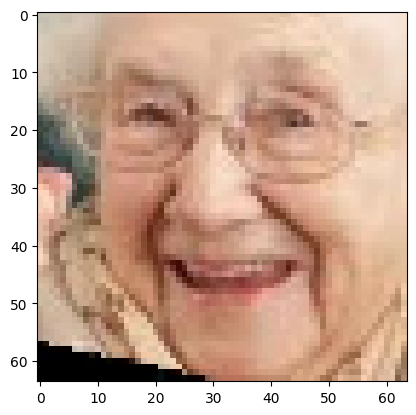

True Gender: Female , True Age: 84 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 85 
 old adult: 80-89 
 Predicted Ethnicity: White


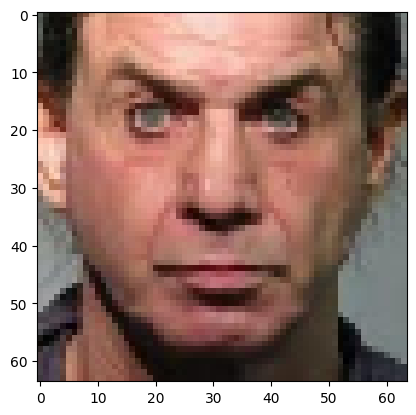

True Gender: Male , True Age: 51 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 45 
 middle-aged adult: 40-49 
 Predicted Ethnicity: White


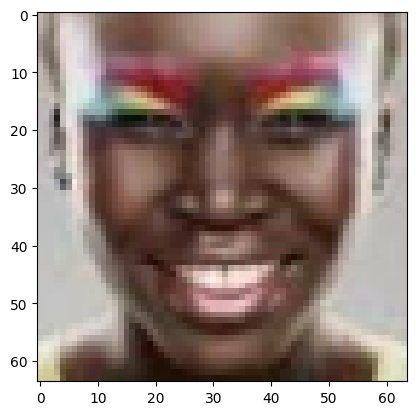

True Gender: Female , True Age: 21 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 29 
 young adult: 20-29  
 Predicted Ethnicity: Black


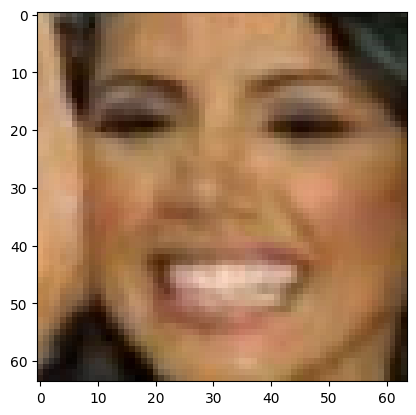

True Gender: Male , True Age: 25 , True Ethnicity:  Hispanic
Predicted Gender: Female 
 Predicted Age: 32 
 young adult: 30-39 
 Predicted Ethnicity: White


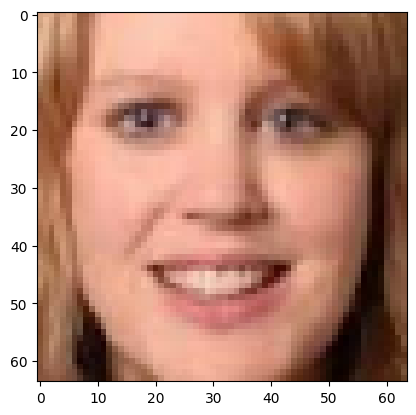

True Gender: Female , True Age: 32 , True Ethnicity:  White
Predicted Gender: Female 
 Predicted Age: 34 
 young adult: 30-39 
 Predicted Ethnicity: White


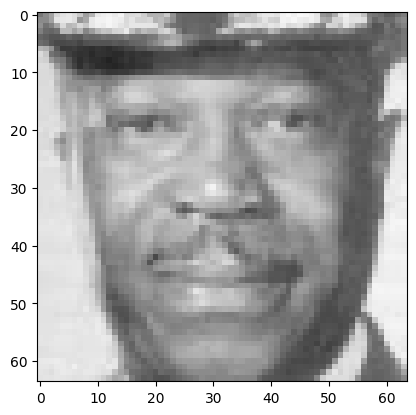

True Gender: Male , True Age: 65 , True Ethnicity:  Black
Predicted Gender: Male 
 Predicted Age: 54 
 middle-aged adult: 50-59 
 Predicted Ethnicity: Black


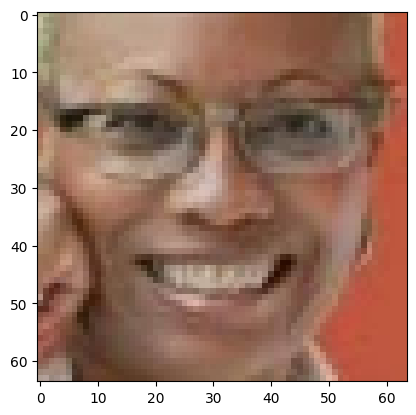

True Gender: Female , True Age: 40 , True Ethnicity:  Black
Predicted Gender: Female 
 Predicted Age: 35 
 young adult: 30-39 
 Predicted Ethnicity: Black


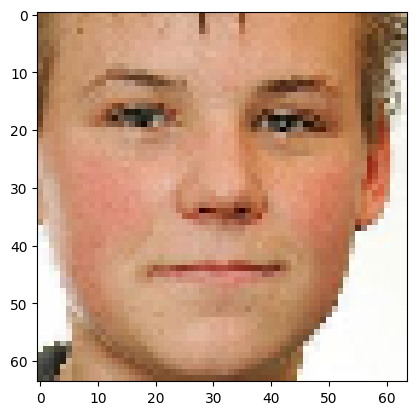

True Gender: Male , True Age: 16 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 20 
 young adult: 20-29  
 Predicted Ethnicity: White


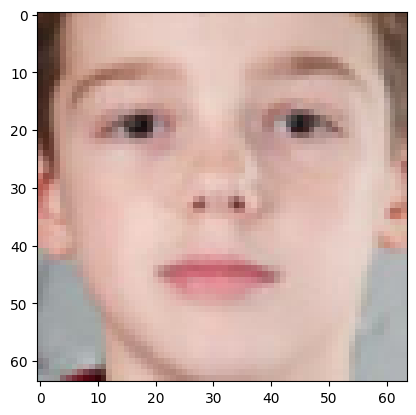

True Gender: Male , True Age: 9 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 0 
 unknown 
 Predicted Ethnicity: White


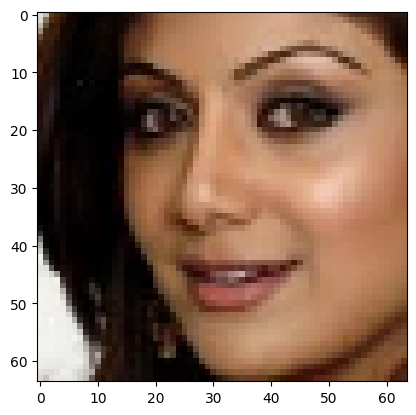

True Gender: Female , True Age: 25 , True Ethnicity:  Indian
Predicted Gender: Female 
 Predicted Age: 29 
 young adult: 20-29  
 Predicted Ethnicity: Indian


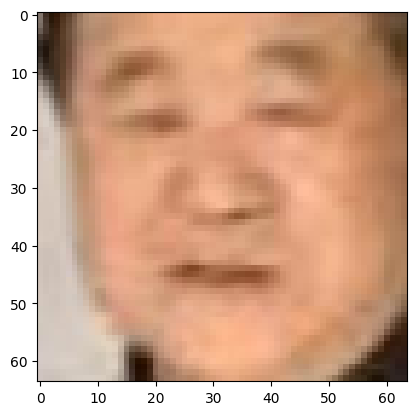

True Gender: Male , True Age: 61 , True Ethnicity:  Asian
Predicted Gender: Male 
 Predicted Age: 51 
 middle-aged adult: 50-59 
 Predicted Ethnicity: Asian


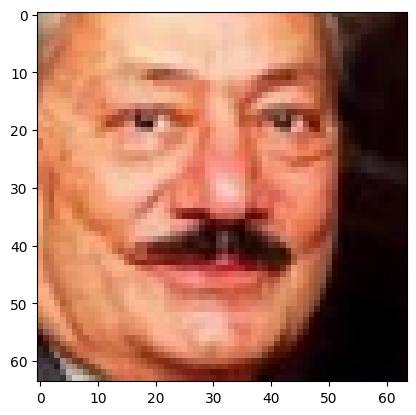

True Gender: Male , True Age: 58 , True Ethnicity:  White
Predicted Gender: Male 
 Predicted Age: 55 
 middle-aged adult: 50-59 
 Predicted Ethnicity: Indian


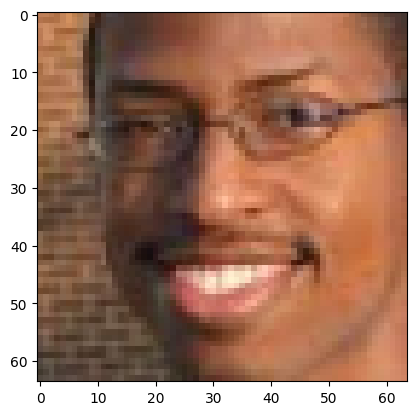

True Gender: Male , True Age: 18 , True Ethnicity:  Black
Predicted Gender: Male 
 Predicted Age: 33 
 young adult: 30-39 
 Predicted Ethnicity: Black


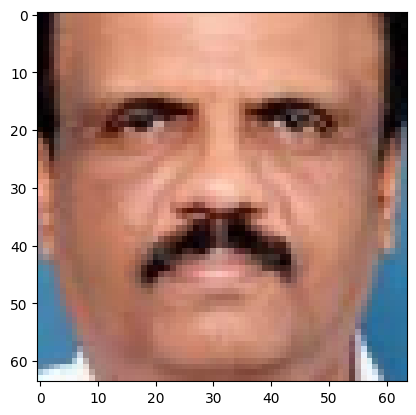

True Gender: Male , True Age: 44 , True Ethnicity:  Indian
Predicted Gender: Male 
 Predicted Age: 48 
 middle-aged adult: 40-49 
 Predicted Ethnicity: Indian


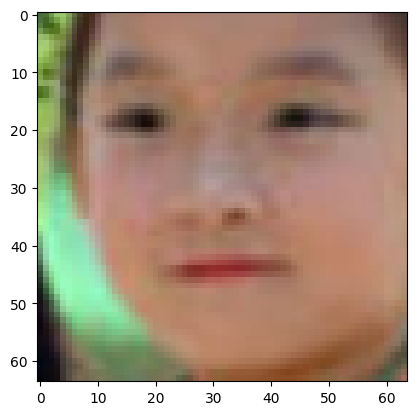

True Gender: Female , True Age: 7 , True Ethnicity:  Asian
Predicted Gender: Female 
 Predicted Age: 0 
 unknown 
 Predicted Ethnicity: Asian


In [41]:

for idx in range(36):
    idx = random.randint(0,len(utk_images))
    sample = utk_images[idx]
    display(sample)
    print("True Gender:",get_gender(genders_list[idx]),", True Age:",ages_list[idx], ", True Ethnicity: ", ethnicity_mapping[ethnicities_list[idx]])
    res = get_result(sample)